In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()


import sys
sys.path.append('/home/yves/Documents/')  ##append your path to this package
import pGPFA


# Overview


## What it does

This package implements a poisson extension of gaussian process factor analysis (gpfa), which has been sucessfully applied to the analysis of data from motor cortex and other areas. The purpose of the model is to reduce the dimensionality of neural population activity data using plausible assumptions (e.g. that the firing rates of neurons are dependent on common inputs and that)


## Model structure

This model assumes that high dimensional population activity is driven by low-dimensional 'latent states', $\textbf{x}$. Latent states are modelled as gaussian processes ($\mathcal{GP}$) and are thus assumed to vary smoothly (on some timescale, which is inferred from data). Our prior distribution over latent states assumes they are independent, though this rarely holds in the posterior, it simplifies inference. The covariance of the state across timepoints is modelled, and hence the $\mathcal{GP}$ specified by the squared exponential kernel

$K(t_1,t_2) = \sigma_2^2 exp(\frac{- (t_1 -t_2)^2}{2\tau^2}) + \sigma_n^2 $

The firing rates of individual neurons, $\textbf{y}$, in a population linearly couple to these latent states (each neuron can have different 'coupling weights') according to $\textbf{C}$. All neurons also have a baseline firing rate $\textbf{d}$. Conditional on the values of the latent states at each timepoint, firing rates are assumed to be poisson distributed:

$\textbf{y}|\textbf{x} \sim \mathcal{P}(\textbf{y}|exp(\textbf{C}\textbf{x} + \textbf{d})$




In [9]:
nlatentDim = 3
y, params = pGPFA.genSim_data_static(n_neurons=120,
                                     nDims=nlatentDim,
                                     n_timePoints = 60,
                                     nTrials=10,
                                     pretty=False)



### Initialise an Instance of the Model

In [25]:
gpfa = pGPFA.model(data=y,
                   t=params['t'],
                   nDims=nlatentDim,
                   epsNoise=1e-6)

initialised! :)


### Fit the model using EM. 

Note that the use of a laplace approximation for inferring the latent states in the E-step means that the $log(\mathcal{L})$ is not necessarily decreasing after each iteration

In [26]:
gpfa.fit(nIter=10)

Running EM iteration 0 || log(L) after M step is: -96181.66 ||  total time elapsed: 2.7s
Running EM iteration 1 || log(L) after M step is: -105071.75 ||  total time elapsed: 5.4s
Running EM iteration 2 || log(L) after M step is: -105593.25 ||  total time elapsed: 7.8s
Running EM iteration 3 || log(L) after M step is: -105967.52 ||  total time elapsed: 10.2s
Running EM iteration 4 || log(L) after M step is: -106152.14 ||  total time elapsed: 13.2s
Running EM iteration 5 || log(L) after M step is: -106216.58 ||  total time elapsed: 17.5s
Running EM iteration 6 || log(L) after M step is: -106221.27 ||  total time elapsed: 22.1s
Running EM iteration 7 || log(L) after M step is: -106224.3 ||  total time elapsed: 25.6s
Running EM iteration 8 || log(L) after M step is: -106219.42 ||  total time elapsed: 28.1s
Running EM iteration 9 || log(L) after M step is: -106201.61 ||  total time elapsed: 30.8s


In [27]:
absIdx = gpfa.get_abs_idx(dset='train',idx=2)

In [28]:
gpfa.params['l']

[array([ 0.00660028]), array([ 0.08223592]), array([ 0.00658848])]

In [29]:
np.max(np.abs(params['latent_traj'][absIdx]))

4.6314367566121097

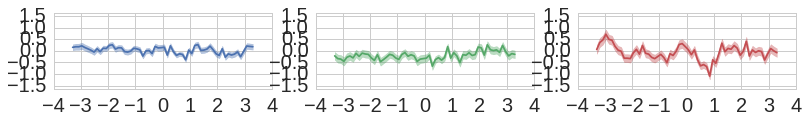

In [30]:
gpfa.plot_latents(trl_idx=2,dset='train')

## Perform Cross Validation on Validation Set

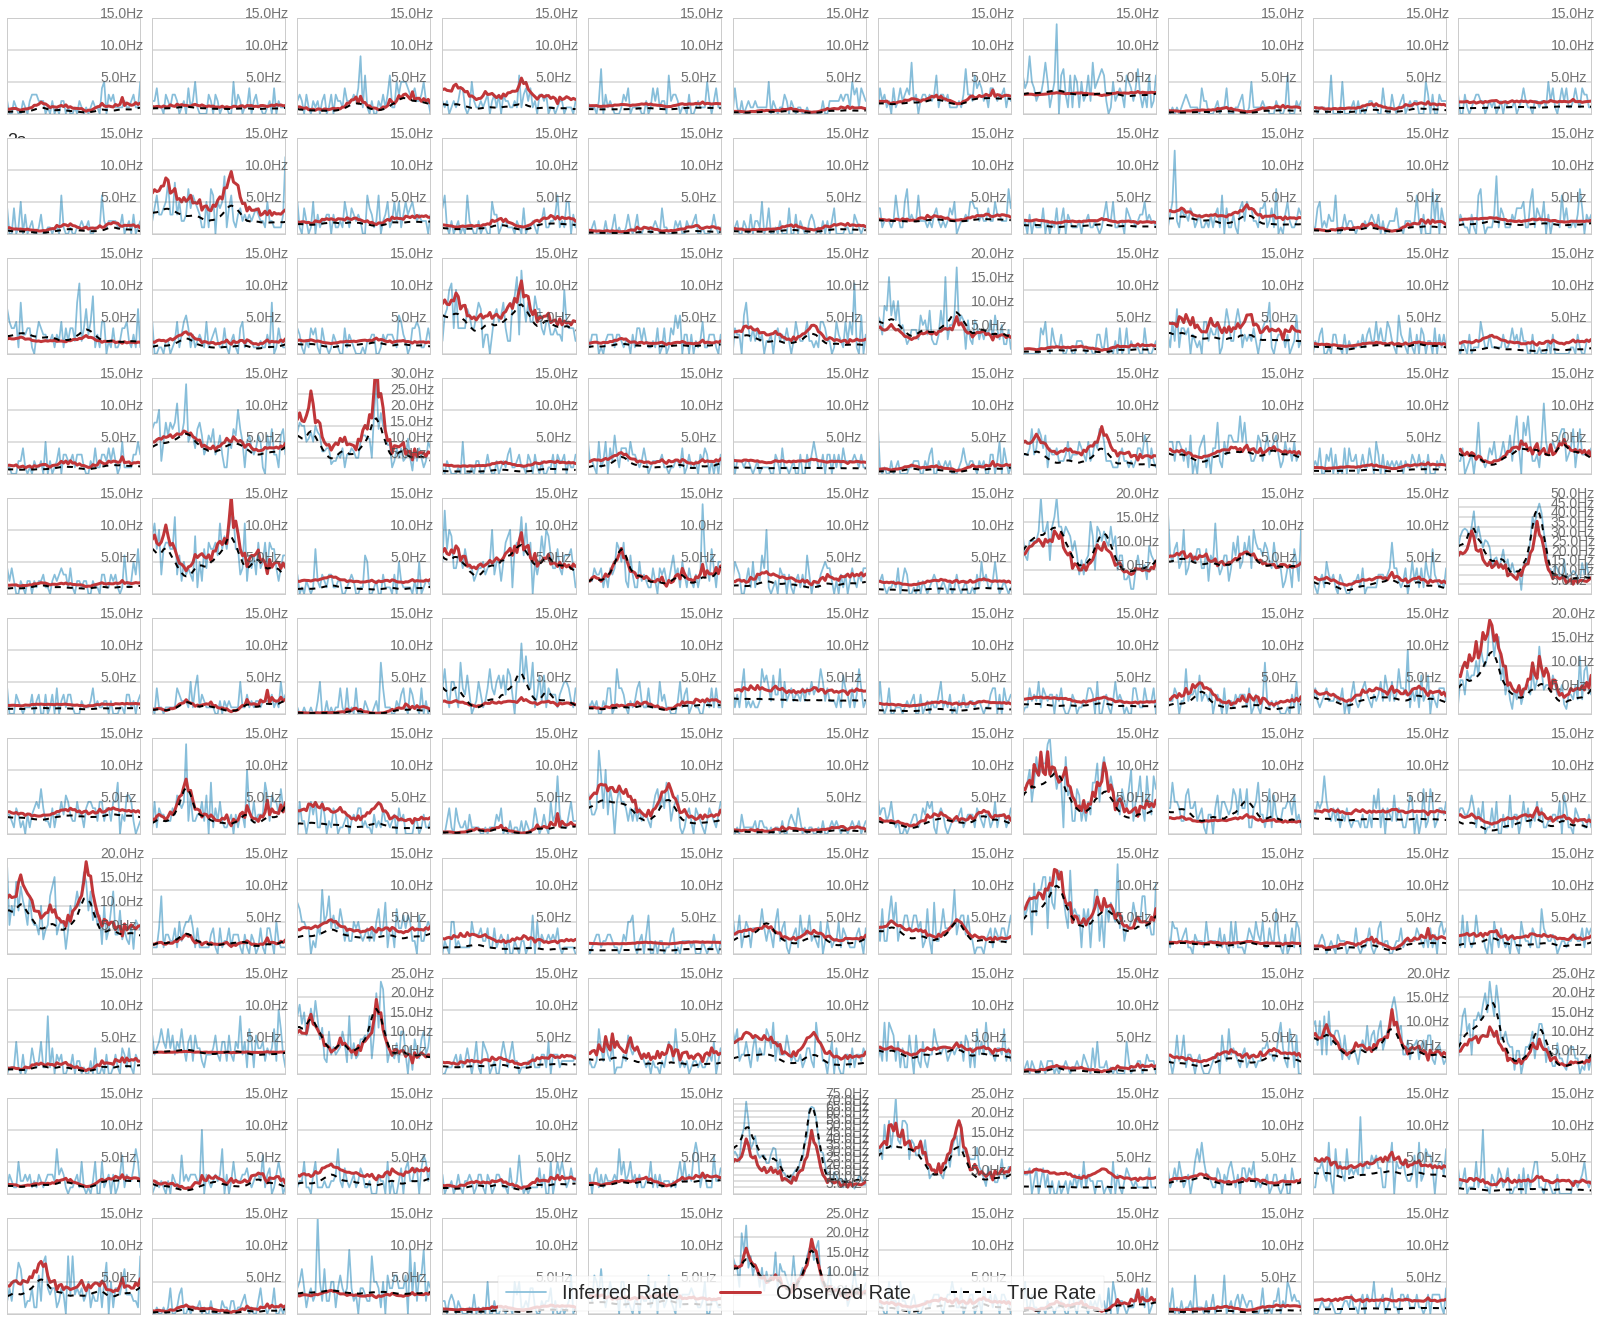

In [31]:
gpfa.test_cross_val()
gpfa.plot_trial_rates(trl_idx=0,
                      dset='validation',ground_truth=params['CIFs'])

# Orthogonalised Latent States

In [32]:
#Do the singular value decomposition
trl_idx = 0
U,D,V = np.linalg.svd(gpfa.params['C'])
xSVD = (np.dot(np.diag(D),V.T).dot(gpfa.params['latent_traj'][trl_idx]))

U,D,V = np.linalg.svd(params['C'])
xSVD_true = (np.dot(np.diag(D),V.T).dot(params['latent_traj'][trl_idx]))

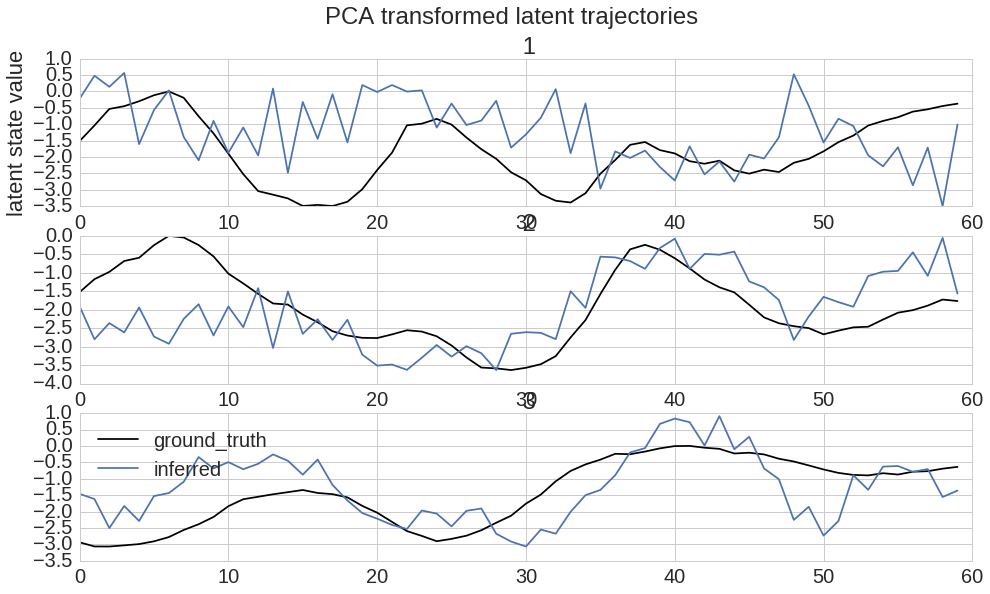

In [33]:
#plot the results
plt.figure(figsize=(16,9))
plt.suptitle('PCA transformed latent trajectories')
for i in range(nlatentDim):
    plt.subplot(3,np.ceil(nlatentDim/3),i+1)
    plt.title(' %s' %(i+1))

    zscore_xsvd_true = (xSVD_true[i]-np.max(xSVD_true[i]))/np.std(xSVD_true[i])
    plt.plot(zscore_xsvd_true,'k',label='ground_truth')
    #plt.plot(true_params['latent_traj'][trl][i].T)
    #plt.plot(params['latent_traj'][trl][i].T)
    if np.corrcoef(xSVD_true[i],xSVD[i])[0,1]<0:
        rev = -1
    else:
        rev = 1
    
    zscore_xsvd = rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i])
    offset = np.min(zscore_xsvd_true) - np.min(zscore_xsvd)
    plt.plot(offset + rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i]),label='inferred')
    if i==0:
        plt.ylabel('latent state value')
    if i==1:
        plt.xlabel('Time (bins)')
plt.legend(loc='best')
plt.savefig('/home/yves/Documents/pGPFA/ims/SVD_states.png')

leave one out r: [0.81696579922613588, 0.89390069749324619, 0.86288394446130057, 0.15784118131032873, 0.32840522050945192, 0.56066764470281971, 0.59731450835852085, 0.34289583499969811, 0.7177728453125416, 0.13859203860482089] full r: [0.89852280701674236, 0.98198541035643416, 0.97569180539060296, 0.2511631734762812, 0.46303333930354118, 0.62394456888871486, 0.65117330134637852, 0.34550877927253587, 0.85246436780746415, 0.18762674806559965]


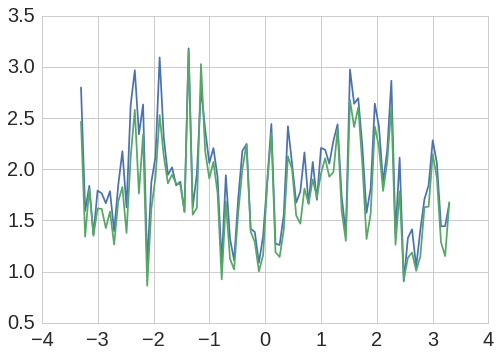

In [45]:
trl_idx = 0

lo_infRates, lo_idxs, post_cov_by_timepoint,x_post_mean = gpfa.leave_n_out(N=10,trl_idx=trl_idx,dset='validation')

corrCoefs = []
for inf,true in zip(lo_infRates,gpfa.dsets['validation'][trl_idx][lo_idxs]):
    corrCoefs.append(np.corrcoef(inf,true)[0,1])
    
    
corrCoefs_full = []
cvInfRates = np.exp(np.dot(gpfa.params['C'],gpfa.CV_inf['validation']['latent_traj'][trl_idx])+gpfa.params['d'][:,None])

for inf2,true in zip(cvInfRates[lo_idxs],gpfa.dsets['validation'][trl_idx][lo_idxs]):

    corrCoefs_full.append(np.corrcoef(inf2,true)[0,1])

plt.plot(params['t'],inf2,label='looCV')
plt.plot(params['t'],inf,label='fullFit')
print "leave one out r: %s full r: %s" %(corrCoefs[0], corrCoefs_full[0])

In [14]:
lo_infRates,lo_idxs,a,b = gpfa.leave_n_out(N=n_out,trl_idx=0,dset='validation')

In [17]:
range(1,79,10)

[1, 11, 21, 31, 41, 51, 61, 71]

In [18]:
res = gpfa.leave_N_out_CV(Ns=range(1,79,10))

0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


In [21]:
len(gpfa.dsets['validation'])

4

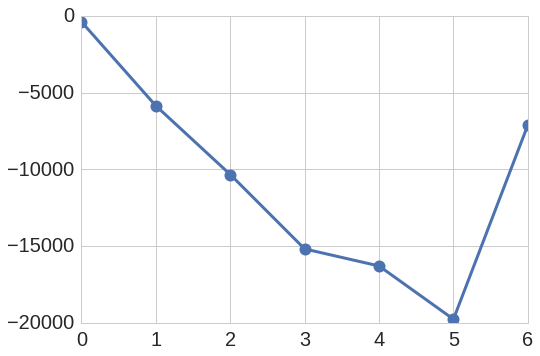

In [38]:
yyu = [np.mean(np.array(res['LL'][i])) for i in range(7)]
plt.plot(yyu,'o-',linewidth=3,markersize=12)

In [19]:
res['LL']

[[[-779.66989095176916,
   78.22127768375455,
   -1388.6189635755829,
   -27.277303957083031],
  [1.893685466896228,
   -395.27503877519018,
   -23.011288914543549,
   -23.011288914111166],
  [-529.70565125759606,
   -480.66609148617033,
   36.06159360411749,
   -529.70565125732696],
  [-1628.978027277662,
   -495.84814885783362,
   156.03267629628925,
   -106.48964063177313]],
 [[-1683.5284855615839,
   -2711.5078099653429,
   -6468.5755572289063,
   -1553.9880161828837],
  [-5591.7888811821349,
   -6336.1415906302691,
   -3353.583530922002,
   -10949.065999521401],
  [-2832.2474043083025,
   -3245.9202802725194,
   -3799.5388209982502,
   -4338.789285284166],
  [-28202.771000981331,
   -3861.3645322637267,
   -3121.8368874181142,
   -5677.7138763179719]],
 [[-14397.667181437362,
   -14614.109693326211,
   -6845.7002114541092,
   -21784.562164968767],
  [-7740.7130007194355,
   -8916.10560824391,
   -10074.873288255967,
   -10083.657478555346],
  [-4585.9404226981997,
   -6042.5537347

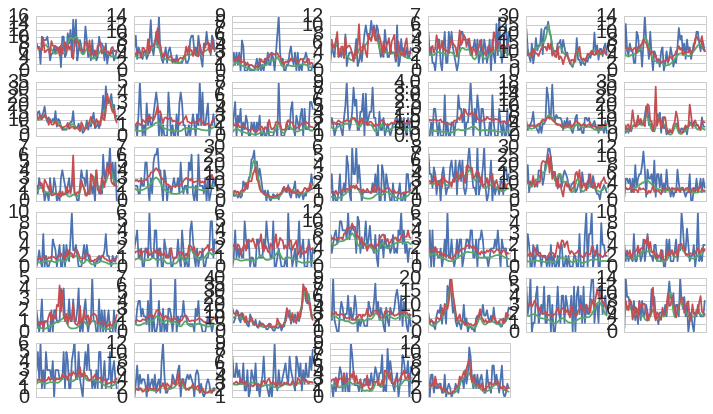

In [33]:
plt.figure(figsize=(12,8))

gt_idx = gpfa.get_abs_idx(idx=0,dset='validation')


nRows = nCols = np.ceil(np.sqrt(n_out))
i = 0
for lo_inf,lo_idx in zip(lo_infRates,lo_idxs):
    plt.subplot(nRows,nCols,i+1)
    
    plt.plot(y[gt_idx][lo_idx])
    plt.plot(params['CIFs'][gt_idx][lo_idx])
    plt.plot(lo_inf)
    plt.xticks([])
    i += 1

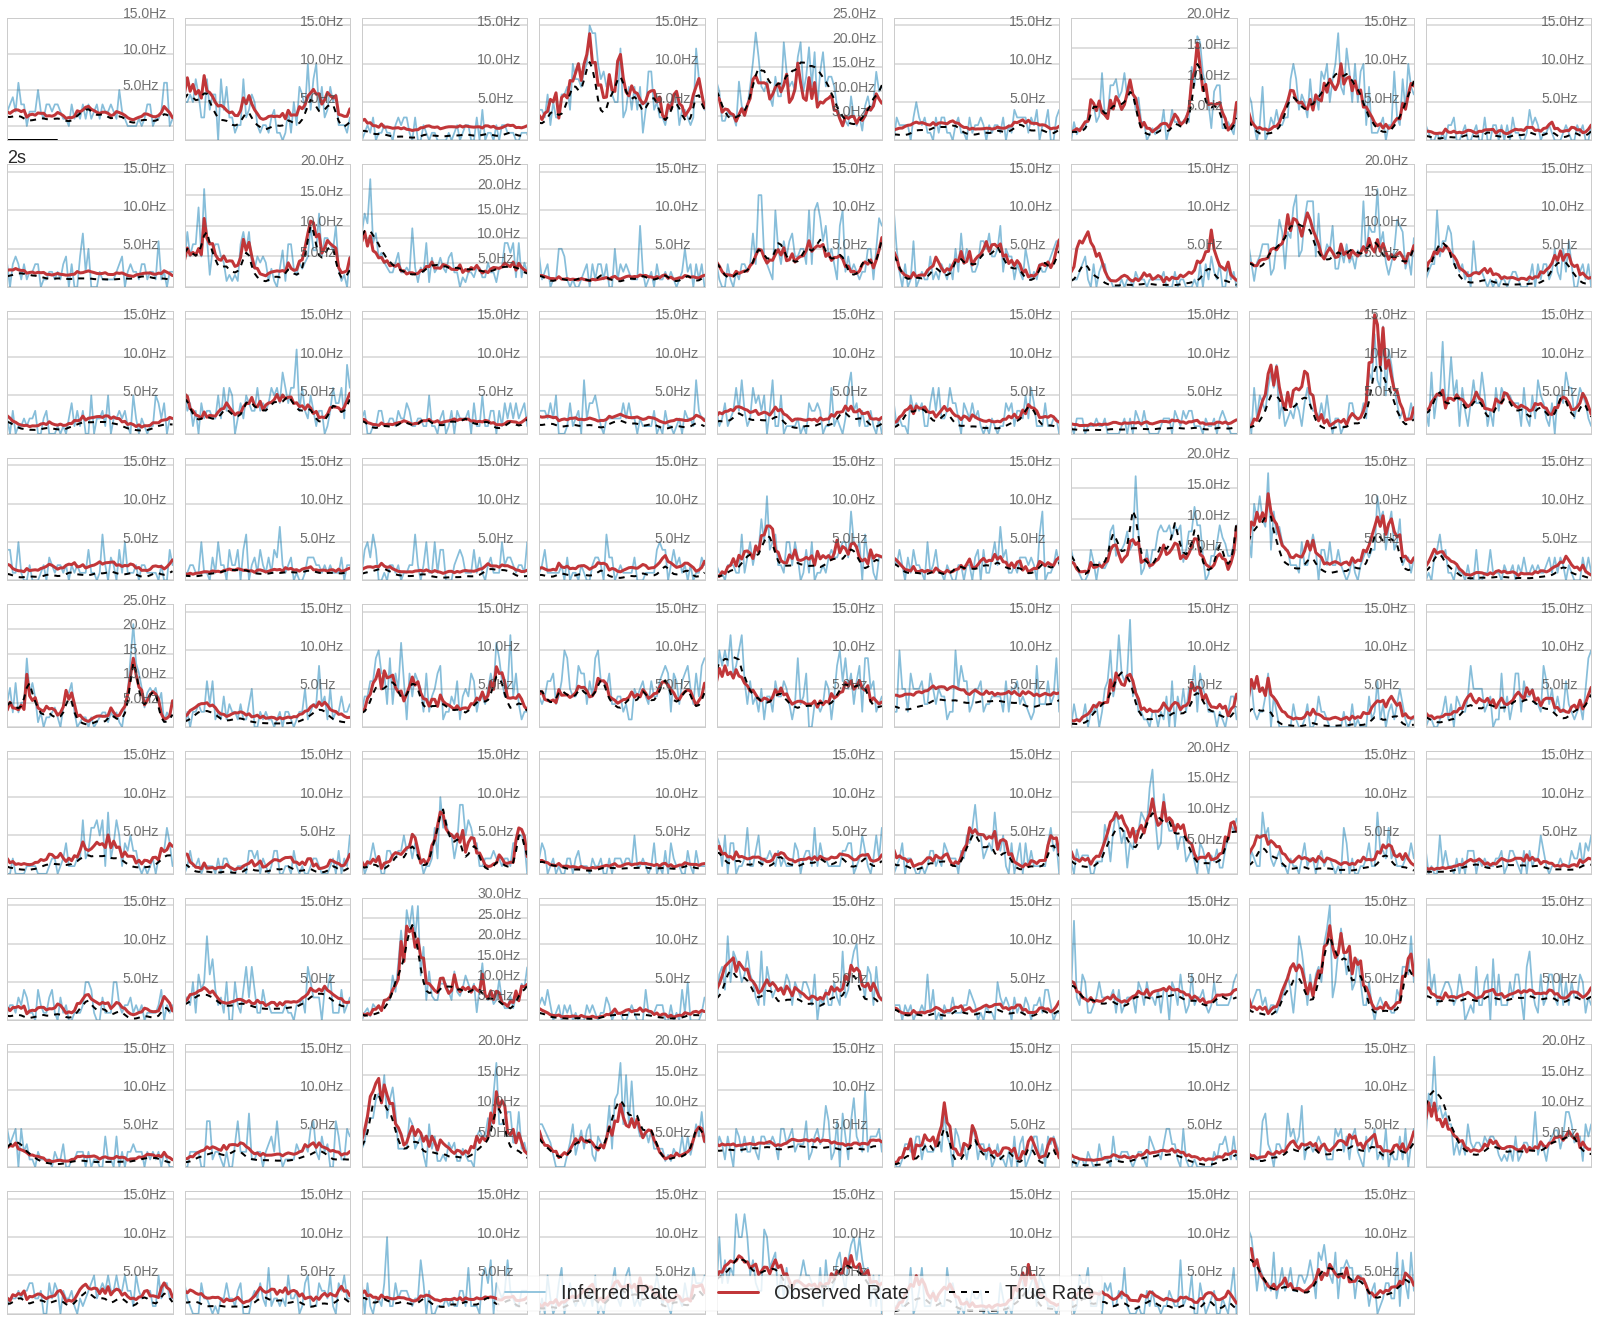

In [8]:
gpfa.plot_trial_rates(trl_idx=0,dset='validation',ground_truth=params['CIFs'])

In [9]:
infR = np.exp(gpfa.params['C'].dot(np.hstack(gpfa.CV_inf['validation']['latent_traj'])))
obsR = np.hstack(gpfa.dsets['validation'])

In [10]:
len(gpfa.CV_inf['validation']['latent_traj'])

2

In [11]:
lo_infRates = gpfa.leave_n_out(N=5,trl_idx=0)

NameError: global name 'op' is not defined

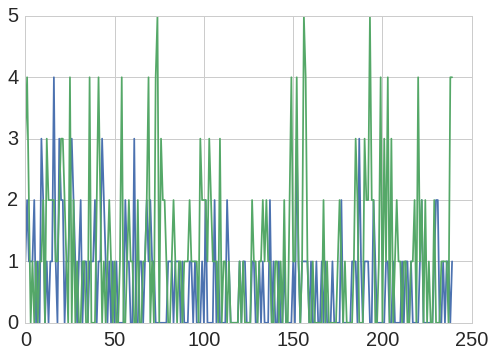

In [37]:
infRates = np.exp(gpfa.params['C'].dot(np.hstack(gpfa.CV_inf['validation']['latent_traj']))+gpfa.params['d'][:,None])

In [101]:
max_iter = 10000
for i in range(max_iter):
    
    obsInfRates = np.random.poisson(infRates)
    if i==0:
        corrMtx_fit = np.corrcoef(obsInfRates)
    else:
        corrMtx_fit += np.corrcoef(obsInfRates)
        
        if np.allclose(corrMtx_fit/i,corrMtx_norm_prev,rtol=1e-4,atol=1e-4):
            print 'calculation of covariance matrix converged after %s iterations' %i
            
            break
    corrMtx_norm_prev = corrMtx_fit/i
        
corrMtx_fit /= nRuns

corrMtx_obs = np.corrcoef(np.hstack(gpfa.dsets['validation']))

calculation of covariance matrix converged after 1802 iterations


In [ ]:
plt.imshow(np.triu(corrMtx_fit))
plt.ylim()

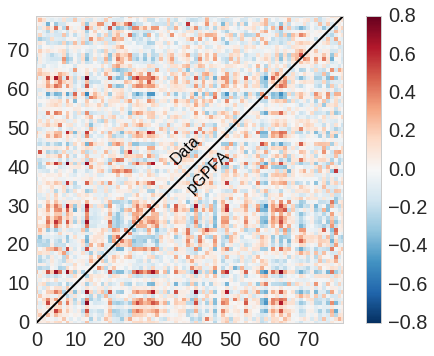

In [97]:
plt.imshow(corr_both,vmin=-.8,vmax=.8,cmap='RdBu_r',interpolation='None')
plt.plot([0,80],[0,80],color='k',linewidth=2)
plt.ylim([0,79])
plt.xlim([0,79])
plt.text(gpfa.n_neurons/2 - 2,gpfa.n_neurons/2 + 2, 'pGPFA',rotation=45,fontsize=16,color='k')
plt.text(gpfa.n_neurons/2 - 6,gpfa.n_neurons/2 + 6, 'Data',rotation=45,fontsize=16,color='k')

plt.grid()

plt.colorbar()
plt.savefig('/home/yves/Desktop/corrMtx.svg')
from PIL import Image

In [98]:
img = Image.open('/home/yves/Desktop/corrMtx.eps')
img2 = img.rotate(45)
img2.show()

###  Plot the inferred Latent Trajectories

In [ ]:
plt.figure(figsize=(18,10))

trl_idx = 1

clrs = seaborn.color_palette(n_colors=gpfa.nDims)


for i in range(nlatentDim):
    plt.subplot(4,np.ceil(nlatentDim/4),i+1)
    plt.title('latent dimension %s' %(i+1))

    x = gpfa.params['latent_traj'][trl_idx][i].T
    std2 = 2*np.sqrt(np.diag(gpfa.params['post_cov_GP'][trl_idx][i]))
    plt.plot(x,color=clrs[i])
    plt.fill_between(range(len(gpfa.params['t'])),x-std2, x +std2,color=clrs[i],alpha=.4)
    if i==1:
        plt.xlabel('Time (bins)')
    if i==0:
        plt.ylabel('Latent State Value')
    plt.savefig('/home/yves/Documents/pGPFA/ims/latent_states.png')

###  To compare to ground truth, compare the z-scored SVD of the true and inferred latent states

In [ ]:
#Do the singular value decomposition

U,D,V = np.linalg.svd(gpfa.params['C'])
xSVD = (np.dot(np.diag(D),V.T).dot(gpfa.params['latent_traj'][trl_idx]))

U,D,V = np.linalg.svd(params['C'])
xSVD_true = (np.dot(np.diag(D),V.T).dot(params['latent_traj'][trl_idx]))

In [ ]:
#plot the results
plt.figure(figsize=(16,9))
plt.suptitle('PCA transformed latent trajectories')
for i in range(nlatentDim):
    plt.subplot(3,np.ceil(nlatentDim/3),i+1)
    plt.title(' %s' %(i+1))

    zscore_xsvd_true = (xSVD_true[i]-np.max(xSVD_true[i]))/np.std(xSVD_true[i])
    plt.plot(zscore_xsvd_true,'k',label='ground_truth')
    #plt.plot(true_params['latent_traj'][trl][i].T)
    #plt.plot(params['latent_traj'][trl][i].T)
    if np.corrcoef(xSVD_true[i],xSVD[i])[0,1]<0:
        rev = -1
    else:
        rev = 1
    
    zscore_xsvd = rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i])
    offset = np.min(zscore_xsvd_true) - np.min(zscore_xsvd)
    plt.plot(offset + rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i]),label='inferred')
    if i==0:
        plt.ylabel('latent state value')
    if i==1:
        plt.xlabel('Time (bins)')
plt.legend(loc='best')
plt.savefig('/home/yves/Documents/pGPFA/ims/SVD_states.png')

## Test Cross Validation features

In [ ]:
gpfa.test_cross_val()

In [ ]:
gpfa.CV_inf['validation'].keys()

In [ ]:
lap

# Plot the Observed, underlying and inferred firing rates of neurons

Note in the plot below, in each panel, the light blue lines are the observed firing rates, the dashed black lines are the underlying (true) firing rates and the orange lines are the inferred firing rates. The vertical black line at the left is a scale bar of 10Hz

In [ ]:
plt.figure(figsize=(22,18))
n_neurons = y[0].shape[0]
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

trl = 0
C = params['C']
x = params['latent_traj']



true_rates = np.exp(params['C'].dot(params['latent_traj'][gpfa.cross_validation['train_idxs'][trl]]).T+params['d']).T
inf_rates = np.exp(gpfa.params['C'].dot(gpfa.params['latent_traj'][trl]).T+gpfa.params['d']).T
for real,sim in zip(true_rates,
                    inf_rates):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        l1,= plt.plot(gpfa.train_data[trl][tt],color=clrs[-2])

        l2, = plt.plot(sim,color=clrs[0],linewidth=3)
        l3, = plt.plot(real,'--',color='k',linewidth=3,alpha=0.9)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.plot([5,5],[0,10],linewidth=3,color='k')
        
        for hh in np.linspace(0,1000,num=201):
            if (hh<=15 or (5+np.max(gpfa.train_data[trl][tt]))>hh):
                plt.plot([0,gpfa.n_timePoints],[hh]*2,color=[.3]*3,alpha=.2,linestyle='-')
       

        
        #plt.ylim()
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)
plt.figlegend((l1,l2,l3),('Inferred Rate','Observed Rate','True Rate'),
              loc = 'lower center',ncol=3,frameon=True,framealpha=.8,labelspacing=36)
plt.savefig('/home/yves/Documents/pGPFA/ims/firing_rates.png')

In [ ]:
#setup
trl_idx = 0

n_neurons = gpfa.n_neurons; n_timePoints = gpfa.n_timePoints; nDims = gpfa.nDims
C = gpfa.params['C']; d = gpfa.params['d'];


In [ ]:
len(np.where(xbar!=0)[0])

In [ ]:
def leave_n_out(self,n):
    a = range(n_neurons)
    lo_idxs = np.random.choice(a,replace=False,size=N)
    C_lo = np.delete(C,lo_idxs,axis=0)
    d_lo = np.delete(d,lo_idxs)
    y_lo = np.delete(gpfa.train_data[trl_idx],lo_idxs,axis=0)


    C_big = pGPFA._util.make_Cbig(C_lo,n_timePoints)


    K_big,_ = pGPFA._util.make_Kbig(gpfa.params,gpfa.params['t'],nDims,epsNoise=1e-3)
    K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)


    x = np.random.normal(size=[nDims,n_timePoints])
    xbar = pGPFA._util.make_xbar(x)
    ybar = pGPFA._util.make_ybar(y_lo)

    resLap = op.minimize(
        fun = pGPFA._lapinf.lap_post_unNorm,
        x0 = x,
        method='Newton-CG',
        args = (ybar, C_big, d_lo, K_bigInv,gpfa.params['t'],n_neurons-N),
        jac = pGPFA._lapinf.lap_post_grad,
        hess = pGPFA._lapinf.lap_post_hess,
        options = {'disp': False,'maxiter': 500,'xtol':1e-16
        })

    x_post_mean = resLap.x.reshape(nDims,n_timePoints,order='F')
    postCov = np.linalg.inv(pGPFA._lapinf.lap_post_hess(resLap.x,ybar, C_big, d_lo,
                        K_bigInv,gpfa.params['t'],n_neurons-N)
                           )
    
    lo_infRates = np.exp(C[lo_idxs].dot(x_post_mean) + d[lo_idxs][:,None])
    return lo_infRates

In [ ]:
N = 2
a = range(n_neurons)
lo_idxs = np.random.choice(a,replace=False,size=N)
C_lo = np.delete(C,lo_idxs,axis=0)
d_lo = np.delete(d,lo_idxs)
y_lo = np.delete(gpfa.train_data[trl_idx],lo_idxs,axis=0)


C_big = pGPFA._util.make_Cbig(C_lo,n_timePoints)


K_big,_ = pGPFA._util.make_Kbig(gpfa.params,gpfa.params['t'],nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)


x = np.random.normal(size=[nDims,n_timePoints])
xbar = pGPFA._util.make_xbar(x)
ybar = pGPFA._util.make_ybar(y_lo)

resLap = op.minimize(
    fun = pGPFA._lapinf.lap_post_unNorm,
    x0 = x,
    method='Newton-CG',
    args = (ybar, C_big, d_lo, K_bigInv,gpfa.params['t'],n_neurons-N),
    jac = pGPFA._lapinf.lap_post_grad,
    hess = pGPFA._lapinf.lap_post_hess,
    options = {'disp': False,'maxiter': 500,'xtol':1e-16
    })



In [ ]:
x_post_mean = resLap.x.reshape(nDims,n_timePoints,order='F')
postCov = np.linalg.inv(pGPFA._lapinf.lap_post_hess(resLap.x,ybar, C_big, d_lo,
                        K_bigInv,gpfa.params['t'],n_neurons-N)
                       )

NameError: name 'lo_idxs' is not defined

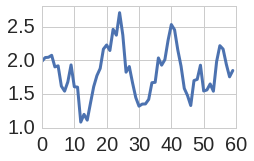

In [10]:
plt.figure(figsize=(16,10))

#infRates = np.exp(C[lo_idxs].dot(x_post_mean) + d[lo_idxs][:,None])
pls = []
trl_idx = 0
N = 5
for i in range(np.min([N,16])):
    ax = plt.subplot(4,4,i+1)
    l1, = ax.plot(lo_infRates[i],
             color=clrs[0],linewidth=3)
    l2, = ax.plot(gpfa.dsets['validation'][trl_idx][lo_idxs[i]],color=clrs[-2])
    l3, = ax.plot(true_rates[lo_idxs[i]],linestyle='--',color='k',linewidth=3)
    plt.xticks([])

plt.figlegend((l1,l2,l3),('Inferred Rate','Observed Rate','True Rate'),loc = 'lower center',ncol=3,frameon=True)

In [ ]:
i = 1

l1, = plt.plot(np.exp(C[lo_idxs[i]].dot(x_post_mean) + d[lo_idxs[i]]),
         color=clrs[0],linewidth=3)
l2, = plt.plot(gpfa.train_data[trl_idx][lo_idxs[i]],color=clrs[-2])
l3, = plt.plot(true_rates[lo_idxs[i]],linestyle='--',color='k',linewidth=3)
plt.xticks([])

In [ ]:
plt.plot(true_rates[])

In [ ]:
params = gpfa.params




In [ ]:
n_timePoints = y[0].shape[1]
n_neurons = y[0].shape[0]
C = gpfa.params['C']; d = gpfa.params['d']




C_big = pGPFA._util.make_Cbig(C,n_timePoints)

nDims = gpfa.params['C'].shape[1]

K_big,_ = pGPFA._util.make_Kbig(gpfa.params,gpfa.params['t'],nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
lapRes = []


In [ ]:
plt.figure(figsize=(6,6))
for idx,sT in enumerate(gpfa.dsets['train'][0]):
    plt.plot(range(gpfa.n_timePoints),12*idx+sT,color=[.3]*3)

In [ ]:
def leaveOneOutPrediction(self):
    '''
    Performs leave-one-out prediction. 
    '''
    print('Performing leave-one-out cross validation...')
    params = self.optimParams
    y_pred_mode_all = []
    pred_err_mode = 0
    for tr in range(self.numTrials):
        y_pred_mode_tr = []
        for nrn in range(self.ydim):
            # Make params without neuron# nrn
            CwoNrn = np.delete(params['C'],nrn,0)
            dwoNrn = np.delete(params['d'],nrn,0)
            paramsSplit = {'C':CwoNrn, 'd':dwoNrn, 'tau':params['tau']}

            # Make params with only neuron# nrn
            C_nrn = params['C'][nrn]
            d_nrn = params['d'][nrn]

            # Make params big
            C_big, d_big = util.makeCd_big(paramsSplit,self.T)
            K_big, K = util.makeK_big(paramsSplit, self.trialDur, self.binSize)
            K_bigInv = np.linalg.inv(K_big)

            # Make data without neuron# nrn
            y = np.delete(self.experiment.data[tr]['Y'],nrn,0)
            ybar = np.ndarray.flatten(np.reshape(y, (self.ydim-1)*self.T))

            xInit = np.ndarray.flatten(np.zeros([self.xdim*self.T,1]))
            res = op.fmin_ncg(
                f = inference.negLogPosteriorUnNorm,
                x0 = xInit,
                fprime = inference.negLogPosteriorUnNorm_grad,
                fhess = inference.negLogPosteriorUnNorm_hess,
                args = (ybar, C_big, d_big, K_bigInv, self.xdim, self.ydim-1),
                disp = False,
                full_output = True)

            x_post_mode = np.reshape(res[0],[self.xdim,self.T])
            y_pred_mode_nrn = np.exp(C_nrn.dot(x_post_mode).T + d_nrn)
            pred_err_mode = pred_err_mode + np.dot(self.experiment.data[tr]['Y'][nrn]-y_pred_mode_nrn,self.experiment.data[tr]['Y'][nrn]-y_pred_mode_nrn)
            y_pred_mode_tr.append(y_pred_mode_nrn)
        y_pred_mode_all.append(y_pred_mode_tr)
    self.y_pred_mode = np.asarray(y_pred_mode_all)
    self.pred_err_mode = pred_err_mode

# Below only plots